In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
#import sys
#!{sys.executable} -m pip install torch==1.4.0+cu92 torchvision==0.5.0+cu92 -f https://download.pytorch.org/whl/torch_stable.html
import torch.nn.functional as F
import torch
import pydicom
import scipy.ndimage
from plotly.tools import FigureFactory as FF
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from skimage import measure
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

In [2]:
def load_scan(path):
    slices = [pydicom.read_file(os.path.join(path, s)) for s in os.listdir(path)]
    slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)

    for s in slices:
        s.SliceThickness = slice_thickness


    image = np.stack([s.pixel_array for s in slices])
    image = image.astype(np.int16)
    return slices, image

def get_pixels_hu(image, slice_list):
    image[image == -2000] = 0


    for slice_number in range(len(slice_list)):

        intercept = slice_list[slice_number].RescaleIntercept
        slope = slice_list[slice_number].RescaleSlope

        if slope != 1:
            image[slice_number] = slope * image[slice_number].astype(np.float64)
            image[slice_number] = image[slice_number].astype(np.int16)

        image[slice_number] += np.int16(intercept)

    return np.array(image, dtype=np.int16)

INPUT_FOLDER = 'D:/research/done/'
patients = os.listdir(INPUT_FOLDER)
patients.sort()
pat=[]
for patient in patients[0:3]:
    print(patient)
    slice_list, image = load_scan(os.path.join(INPUT_FOLDER, patient))
    print(type(slice_list))
    pat=slice_list
    print("slice thickness: ",slice_list[0].SliceThickness)
    print("Pixel Spacing (row, col): (%f, %f) " % (slice_list[0].PixelSpacing[0], slice_list[0].PixelSpacing[1]))
    image = get_pixels_hu(image, slice_list)
    #print(image)
    #np.save(os.path.join('3D_ARRAY_KUN', 'CT_3D_{}.npy'.format(patient)), image)


path1='D:/research/90_epoch/CT_3D_Patient163_G_fake.npy'
path2='D:/research/90_epoch/CT_3D_Patient164_G_fake.npy'
imgs_to_process1=np.load(path1)
imgs_to_process2=np.load(path2)

Patient1
<class 'list'>
slice thickness:  2.5
Pixel Spacing (row, col): (0.703125, 0.703125) 
Patient10
<class 'list'>
slice thickness:  1.25
Pixel Spacing (row, col): (0.878906, 0.878906) 
Patient100
<class 'list'>
slice thickness:  1.25
Pixel Spacing (row, col): (0.876953, 0.876953) 


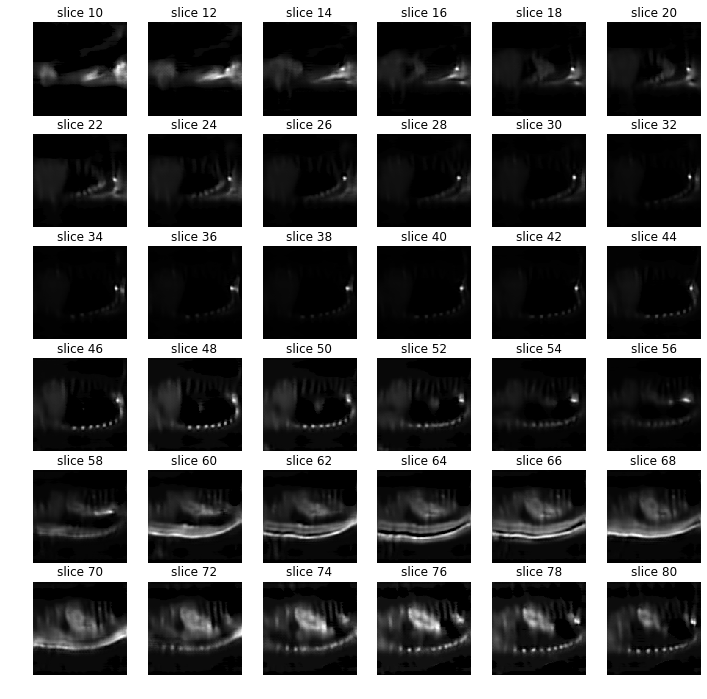

In [3]:
def sample_stack(stack, rows=6, cols=6, start_with=10, show_every=2):
    fig,ax = plt.subplots(rows,cols,figsize=[12,12])
    for i in range(rows*cols):
        ind = start_with + i*show_every
        ax[int(i/rows),int(i % rows)].set_title('slice %d' % ind)
        ax[int(i/rows),int(i % rows)].imshow(stack[ind],cmap='gray')
        ax[int(i/rows),int(i % rows)].axis('off')
    plt.show()

sample_stack(imgs_to_process1)
#sample_stack(imgs_to_process2)

In [4]:
def resample(image, scan, new_spacing=[1, 1, 1]):
    # Determine current pixel spacing
    spacing = map(float, ([scan[0].SliceThickness] + list(scan[0].PixelSpacing)))
    spacing = np.array(list(spacing))

    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape).astype('int32')
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor

    #image = scipy.ndimage.interpolation.zoom(image, real_resize_factor)
    image = F.interpolate(torch.Tensor(image).unsqueeze(0).unsqueeze(0), new_shape.tolist(), mode='trilinear',
                             align_corners=True).squeeze().detach().numpy()

    return image, new_spacing

print(pat)
print("Shape before resampling", imgs_to_process1.shape)
imgs_after_resamp, spacing = resample(imgs_to_process1, pat, [1,1,1])
print ("Shape after resampling", imgs_after_resamp.shape, type(imgs_after_resamp),spacing)

[(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'AXIAL']
(0008, 0016) SOP Class UID                       UI: CT Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.3.6.1.4.1.14519.5.2.1.6279.6001.308512940895720031701709925623
(0008, 0020) Study Date                          DA: '20000101'
(0008, 0021) Series Date                         DA: '20000101'
(0008, 0022) Acquisition Date                    DA: '20000101'
(0008, 0023) Content Date                        DA: '20000101'
(0008, 0024) Overlay Date                        DA: '20000101'
(0008, 0025) Curve Date                          DA: '20000101'
(0008, 002a) Acquisition DateTime                DT: '20000101'
(0008, 0030) Study Time                          TM: '175403'
(0008, 0032) Acquisition Time                    TM: '175725'
(0008, 0033) Content Time                        TM: '180123'
(0008, 0050) Accession Nu

(7fe0, 0010) Pixel Data                          OW: Array of 524288 elements]
Shape before resampling (128, 128, 128)
Shape after resampling (160, 112, 112) <class 'numpy.ndarray'> [1.       1.002232 1.002232]


Transposing surface
(128, 128, 128)
Calculating surface
v (7562, 3)
f [[   2    1    0]
 [   3    2    0]
 [   5    4    2]
 ...
 [7453 7561 7556]
 [7453 7560 7561]
 [7556 7561 7557]]
n [[ 0.15935202 -0.7362009  -0.6577349 ]
 [ 0.1761894  -0.3972985  -0.9006171 ]
 [ 0.16690525 -0.7381749  -0.6536363 ]
 ...
 [-0.32462794  0.9314765  -0.16422027]
 [-0.35757375  0.92556983  0.1243441 ]
 [-0.51602525  0.7771219   0.36027697]]
v [175.99504 175.99504 175.99504 ... 270.58267 208.9748  198.075  ]
Drawing


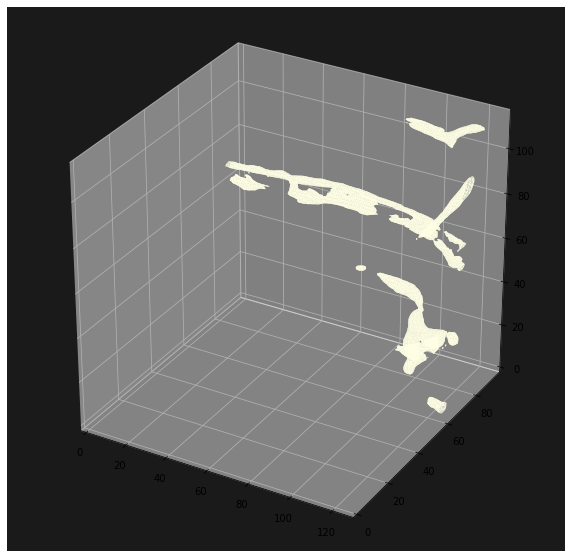

In [5]:
def make_mesh(image, threshold=-300, step_size=1):
    print("Transposing surface")
    p = image.transpose(2, 1, 0)
    print(p.shape)

    print("Calculating surface")
    verts, faces, norm, val = measure.marching_cubes_lewiner(p, threshold, step_size=step_size, allow_degenerate=True)
    print ("v",verts.shape)
    print("f",faces)
    print("n",norm) 
    print("v",val)
    return verts, faces


def plotly_3d(verts, faces):
    x, y, z = zip(*verts)

    print ("Drawing")

    # Make the colormap single color since the axes are positional not intensity.
    #colormap=['rgb(255,105,180)','rgb(255,255,51)','rgb(0,191,255)']
    colormap = ['rgb(236, 236, 212)', 'rgb(236, 236, 212)']
    

    fig = FF.create_trisurf(x=x,
                            y=y,
                            z=z,
                            plot_edges=False,
                            colormap=colormap,
                            simplices=faces,
                            backgroundcolor='rgb(64, 64, 64)',
                            title="Interactive Visualization")
    iplot(fig)


def plt_3d(verts, faces):
    print("Drawing")
    x, y, z = zip(*verts)
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], linewidths=0.05, alpha=1)
    face_color = [1, 1, 0.9]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, max(x))
    ax.set_ylim(0, max(y))
    ax.set_zlim(0, max(z))
    #ax.set_axis_bgcolor((0.7, 0.7, 0.7))
    ax.patch.set_facecolor((0.10, 0.10, 0.10))
    #plt.savefig("./plot/3d_i2_106_2.png")
    #plt.show()

v, f = make_mesh(imgs_to_process1, 350)
plt_3d(v, f)



In [6]:
v, f = make_mesh(imgs_to_process2, 350, 2)
plotly_3d(v, f)

Transposing surface
(128, 128, 128)
Calculating surface
v (1793, 3)
f [[   2    1    0]
 [   0    3    2]
 [   1    4    0]
 ...
 [1790 1724 1726]
 [1792 1727 1725]
 [1727 1792 1726]]
n [[-0.3244908   0.850119   -0.41473296]
 [-0.06924552  0.34247375 -0.93697214]
 [ 0.19849676 -0.751992   -0.6285755 ]
 ...
 [ 0.44218215  0.12915795  0.8875771 ]
 [ 0.5038968   0.6270309  -0.5940709 ]
 [ 0.45704913  0.8576363  -0.2357246 ]]
v [295.29443 309.8358  309.8358  ... 364.85602 371.4873  371.4873 ]
Drawing


d:\polynomial\venv\lib\site-packages\plotly\tools.py:592: UserWarning:

plotly.tools.FigureFactory.create_trisurf is deprecated. Use plotly.figure_factory.create_trisurf



In [15]:
#v, f = make_mesh(imgs_to_process2, 350)
#plt_3d(v, f)

In [7]:
v, f = make_mesh(imgs_to_process2, 350, 2)
plotly_3d(v, f)

Transposing surface
(128, 128, 128)
Calculating surface
v (1793, 3)
f [[   2    1    0]
 [   0    3    2]
 [   1    4    0]
 ...
 [1790 1724 1726]
 [1792 1727 1725]
 [1727 1792 1726]]
n [[-0.3244908   0.850119   -0.41473296]
 [-0.06924552  0.34247375 -0.93697214]
 [ 0.19849676 -0.751992   -0.6285755 ]
 ...
 [ 0.44218215  0.12915795  0.8875771 ]
 [ 0.5038968   0.6270309  -0.5940709 ]
 [ 0.45704913  0.8576363  -0.2357246 ]]
v [295.29443 309.8358  309.8358  ... 364.85602 371.4873  371.4873 ]
Drawing


d:\polynomial\venv\lib\site-packages\plotly\tools.py:592: UserWarning:

plotly.tools.FigureFactory.create_trisurf is deprecated. Use plotly.figure_factory.create_trisurf



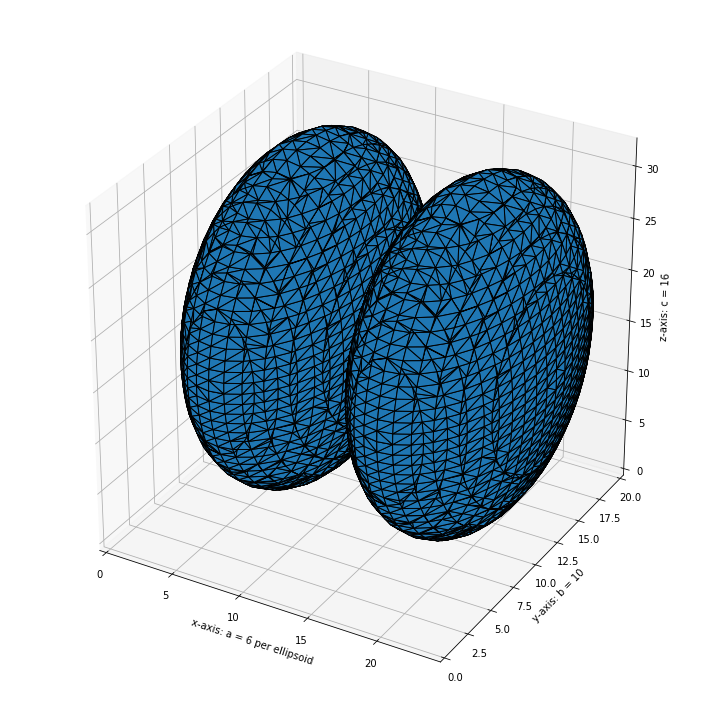

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

from skimage import measure
from skimage.draw import ellipsoid


# Generate a level set about zero of two identical ellipsoids in 3D
ellip_base = ellipsoid(6, 10, 16, levelset=True)
ellip_double = np.concatenate((ellip_base[:-1, ...],
                               ellip_base[2:, ...]), axis=0)

# Use marching cubes to obtain the surface mesh of these ellipsoids
verts, faces, normals, values = measure.marching_cubes_lewiner(ellip_double, 0)

# Display resulting triangular mesh using Matplotlib. This can also be done
# with mayavi (see skimage.measure.marching_cubes_lewiner docstring).
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Fancy indexing: `verts[faces]` to generate a collection of triangles
mesh = Poly3DCollection(verts[faces])
mesh.set_edgecolor('k')
ax.add_collection3d(mesh)

ax.set_xlabel("x-axis: a = 6 per ellipsoid")
ax.set_ylabel("y-axis: b = 10")
ax.set_zlabel("z-axis: c = 16")

ax.set_xlim(0, 24)  # a = 6 (times two for 2nd ellipsoid)
ax.set_ylim(0, 20)  # b = 10
ax.set_zlim(0, 32)  # c = 16

plt.tight_layout()
plt.show()